In [86]:
%%capture
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import importlib as imp

from collections import namedtuple
from random import sample, shuffle
from functools import reduce
from itertools import accumulate
from math import floor, ceil, sqrt, log, pi
from matplotlib import pyplot as plt
from tensorflow.keras import layers, utils, losses, models as mds, optimizers

if imp.util.find_spec('aggdraw'): import aggdraw
if imp.util.find_spec('tensorflow_addons'): from tensorflow_addons import layers as tfa_layers
if imp.util.find_spec('tensorflow_models'): from official.vision.beta.ops import augment as visaugment
if imp.util.find_spec('tensorflow_probability'): from tensorflow_probability import distributions as tfd

In [47]:
# Dataset image size
IMG_SIZE = 264
N_CLASSES = 102

def preprocess(image, *args):
    image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
    image /= 255
    return (image, *args)

train_ds, val_ds = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation'],
    as_supervised=True,
    read_config=tfds.ReadConfig(try_autocache=False)
)

train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

## Image Augmentation

### AutoAugment

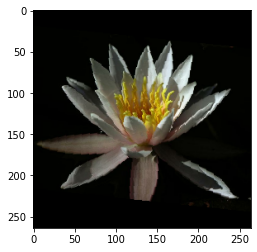

In [31]:
policies = [
    [('Rotate', 0.7, 2), ('TranslateX', 0.3, 2)],
    [('TranslateX', 0.3, 2), ('TranslateY', 0.4, 3)],
    [('AutoContrast', 0.5, 3), ('Brightness', 0.9, 6)],
    [('Rotate', 0.7, 2), ('Color', 0.2, 1)],
]
augmenter = visaugment.AutoAugment(policies=policies)

def aug_fn(image, label):
    image = tf.cast(image*255, tf.uint8)
    image = augmenter.distort(image)
    image = tf.cast(image, tf.float32)
    image /= 255
    
    return image, label

tds = train_ds.map(aug_fn, num_parallel_calls=tf.data.AUTOTUNE)
itr = iter(tds)
plt.imshow(next(itr)[0])

### RandAugment

In [7]:
augmenter = visaugment.RandAugment()

def randaug_pp(image, label):
    image = tf.cast(image*255, tf.uint8)
    image = augmenter.distort(image)
    image = tf.cast(image, tf.float32)
    image /= 255
    
    return image, label

tds = train_ds.map(randaug_pp, num_parallel_calls=tf.data.AUTOTUNE)

ModuleNotFoundError: No module named 'official'

### Basic Augment

Text(0.5, 1.0, 'No Augmentation')

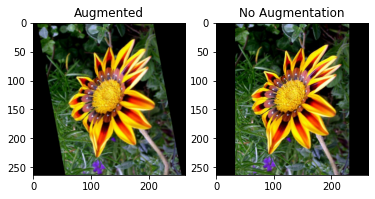

In [83]:
augs = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  # layers.RandomContrast(.2),
])

noaug_ds = train_ds.batch(2)
tds = train_ds.batch(2)
tds = tds.map(lambda x,y: (augs(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
itr, noaug_itr = iter(tds), iter(noaug_ds)

fig, axes = plt.subplots(1,2, facecolor='w', edgecolor='k')
next(itr), next(noaug_itr)

axes[0].imshow(next(itr)[0][0])
axes[1].imshow(next(noaug_itr)[0][0])

axes[0].set_title('Augmented')
axes[1].set_title('No Augmentation')



### Mixup

Text(0.5, 1.0, 'Augmented')

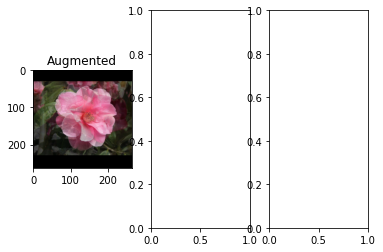

In [131]:
BATCH_SIZE = 2

def expand_labels(image, label):
    label = tf.one_hot(label, N_CLASSES)
    return image, label

def mix_values(item1, item2, l):
    item = l*item1 + (1-l)*item2
    return item

def mix_fn(item1, item2):
    image1, label1 = item1
    image2, label2 = item2

    l = tfd.Beta(5, 20).sample()

    image = mix_values(image1, image2, l)
    label = mix_values(label1, label2, l)
    return image, label

tds1 = train_ds.skip(1).map(expand_labels, num_parallel_calls=tf.data.AUTOTUNE)
tds2 = tds1.shuffle(BATCH_SIZE*20)
tds2 = tds1.skip(100)
noaug_ds = tf.data.Dataset.zip((tds1, tds2)).batch(BATCH_SIZE)
tds = noaug_ds.map(mix_fn, num_parallel_calls=tf.data.AUTOTUNE)
vds = val_ds.batch(BATCH_SIZE).map(expand_labels, num_parallel_calls=tf.data.AUTOTUNE).cache()

fig, axes = plt.subplots(1,3, facecolor='w', edgecolor='k')
itr, noaug_itr = iter(tds), iter(noaug_ds)

image, label = next(itr)[0]
axes[0].imshow(image)
axes[0].set_title('Augmented')

# item1, item2 = next(noaug_itr)
# image1, label1 = item1[0]
# image2, label2 = item2[0]

# axes[1].imshow(image1)
# axes[2].imshow(image2)

# axes[1].set_title('No Augmentation')
# axes[2].set_title('No Augmentation')

### Mixup with Basic Augmentation

0.244025469
0.253272086
0.311112642
0.325592279
0.218947232


Text(0.5, 1.0, 'No Augmentation')

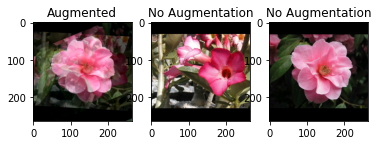

In [134]:
BATCH_SIZE = 2

augs = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomContrast(.2),
])

def aug_fn(item1, item2):
    image1, label1 = item1
    image2, label2 = item2

    image1 = augs(image1, training=True)
    image2 = augs(image2, training=True)

    return ((image1, label1), (image2, label2))

def expand_labels(image, label):
    label = tf.one_hot(label, N_CLASSES)
    return image, label

def mix_values(item1, item2, l):
    item = l*item1 + (1-l)*item2
    return item

def mix_fn(item1, item2):
    image1, label1 = item1
    image2, label2 = item2

    l = tfd.Beta(5, 20).sample()
    tf.print(l)

    image = mix_values(image1, image2, l)
    label = mix_values(label1, label2, l)
    return image, label

tds1 = train_ds.skip(1).map(expand_labels, num_parallel_calls=tf.data.AUTOTUNE)
tds2 = tds1.shuffle(BATCH_SIZE*20)
# tds2 = tds1.skip(100)
noaug_ds = tf.data.Dataset.zip((tds1, tds2)).batch(BATCH_SIZE)
tds = noaug_ds.map(aug_fn, num_parallel_calls=tf.data.AUTOTUNE)
tds = tds.map(mix_fn, num_parallel_calls=tf.data.AUTOTUNE)
vds = val_ds.batch(BATCH_SIZE).map(expand_labels, num_parallel_calls=tf.data.AUTOTUNE).cache()

fig, axes = plt.subplots(1,3, facecolor='w', edgecolor='k')
itr, noaug_itr = iter(tds), iter(noaug_ds)

image, label = next(itr)[0]
axes[0].imshow(image)
axes[0].set_title('Augmented')

item1, item2 = next(noaug_itr)
image1, _ = item1[0]
image2, _ = item2[0]

axes[1].imshow(image1)
axes[2].imshow(image2)

axes[1].set_title('No Augmentation')
axes[2].set_title('No Augmentation')

In [126]:
tds1.skip(100)

<SkipDataset element_spec=(TensorSpec(shape=(264, 264, 3), dtype=tf.float32, name=None), TensorSpec(shape=(102,), dtype=tf.float32, name=None))>